# Simulation study 
**proving, that cross-sectional normative models are good enough for longitudinal data analysis**

In [3]:
# Loading packages
import os, glob, pickle, time, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pcntoolkit.util.utils import create_design_matrix

# custom functions
code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)
import clinics_desc_functions as custom

custom.set_seed(seed=42)

Random seed 42 has been set.


definition of paths to directories

In [4]:
project_dir = ('/home/barbora/Documents/Projects/Normative_Models')
simulations_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/simulations'
models_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/models/lifespan_57K_82sites/'
models_pretrained_all = '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/'
paper_im_dir = os.path.join(project_dir,'ESO', 'draft', 'img')

which IDP are we going to model?

In [5]:
import clinics_desc_functions as custom
# pretrained model
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

random_idp = idp_ids[15]#np.random.randint(len(idp_ids), size=1)

# one random model - just trying to get some reasonable coeffitients
model_path = os.path.join(models_dir,random_idp,'Models')

-------------------------------------------------------------------------------------------------------------------

custom functions for the script
- generate controls data
- generate patients data
- function for plotting of longitudinal data

In [6]:
# Function to generate Subjects
def generate_longitudinal_subjects(model_path, simulations_dir, no_females = 1000, var_population = 1, var_noise = 0.5, effect='none', effect_size = 0, effect_var = 0):
    """
    Function will generate brain data based on coeffitiens from chosen model
    generate_longitudinal_subjects(model_path, simulations_dir, no_females = 1000, var_population = 1, var_noise = 0.5):
    
    model_path... path of model with coeffitients
    simulations_dir... where the results are to be stored
    no_females... number of females (dataset is going to be twice the size, default = 1000)
    var_population... variation in population (default = 1)
    var_noise... variation in noise (default = 0.5)
    effect...   - none (use to generate controls)
                - uniform
                - normal
    effect_size... effect size (default = 0)
    effect_var... effect variation (default = 0)
    """
    from pcntoolkit.normative import estimate, predict, evaluate

    # Create template dataset for V1 and V2
    #elems = np.arange(18,60,1)
    #v1_age = np.repeat(elems,no_females/100)
    #v1_age = np.concatenate([v1_age,v1_age])
    v1_age = np.random.randint(18,60,size=no_females*2)
    

    v2_age = v1_age+1

    sex = np.concatenate([np.zeros([no_females]),np.ones([no_females])])
    id = ['c'+str(i) for i in range(1,no_females*2+1)]

    v1_template = pd.DataFrame(np.array([v1_age,sex]).T, columns=['age', 'sex'], index=id)
    v2_template = pd.DataFrame(np.array([v2_age,sex]).T, columns=['age', 'sex'], index=id)

    v1_template['site'] = 'simulation'
    v1_template['sitenum'] = 4223
    v2_template['site'] = 'simulation'
    v2_template['sitenum'] = 4223

    # Deterministic part of the simulation
    # phi(x)*w --> Yhat
    cols_cov = ['age','sex']
    v1_covars = create_design_matrix(v1_template[cols_cov], 
                                site_ids = v1_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)

    v2_covars = create_design_matrix(v2_template[cols_cov], 
                                site_ids = v2_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)


    v1_fsaveto = os.path.join(simulations_dir,'v1_controls.txt')
    np.savetxt(v1_fsaveto, v1_covars)
    v2_fsaveto = os.path.join(simulations_dir,'v2_controls.txt')
    np.savetxt(v2_fsaveto, v2_covars)

    from temp_func_pcn import predict
    v1_template['Yhat'], v1_s2_orig = predict(v1_fsaveto, respfile = None, alg='blr', model_path=model_path)
    v2_template['Yhat'], v2_s2_orig = predict(v2_fsaveto, respfile = None, alg='blr', model_path=model_path)

    # Adding the position within the population to every individual
    np.random.seed(42)

    if var_population == 'model':
        with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, v1_covars)        
        v1_template['pop'] = np.random.normal(0, 1/beta, size=v1_template.shape[0])
        beta = 1/beta
    else:
        v1_template['pop'] = np.random.normal(0,var_population,size=v1_template.shape[0])
        beta = var_population + var_noise

    # Adding the effect if there is any (controls vs patients)
    if effect == 'none':
        effect_size = 0
    elif effect == 'normal':
        effect_size = np.random.normal(effect_size, effect_var, size=no_patients)
    elif effect == 'uniform':
        effect_size = effect_size

    v1_template['effect_size'] = effect_size
    v1_template['Yhat_pop'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['effect_size']
    v1_template['noise'] = np.random.normal(0,var_noise,size=v1_template.shape[0])
    v1_template['warped'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['effect_size'] + v1_template['noise']

    v2_template['pop'] = v1_template['pop']
    v2_template['effect_size'] = effect_size
    v2_template['Yhat_pop'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['effect_size']
    v2_template['noise'] = np.random.normal(0,var_noise,size=v2_template.shape[0])
    v2_template['warped'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['effect_size'] + v2_template['noise']


    # Now warping into the original space
    # load the normative model
    with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    v1_template[random_idp] = W.warp_predictions(np.squeeze(v1_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]
    v2_template[random_idp] = W.warp_predictions(np.squeeze(v2_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]

    return(v1_template, v2_template, beta)

# LONGITUDINAL PLOTTING FUNCTION
# check the controls are not dramatically different between the two visits
# x coordinates - age - two rows of data
def plot_longitudinal(v1_age, v2_age,  v1_Yhat, v2_Yhat, to_plot = True, v1_col='lightblue', v2_col='lightcoral', tick_col = 'gray', title = '', xlabel = 'Age', ylabel = 'Yhat'):
    """
    The function will plot the longitudinal data as connected dots
    plot_longitudinal(v1_age, v2_age,  v1_Yhat, v2_Yhat, to_plot = True, v1_col='lightblue', v2_col='lightcoral', tick_col = 'gray', title = '', xlabel = 'Age', ylabel = 'Yhat')
    
    v1_age, v2_age... what will be plotted on x axis, ideally 1xn 2D array
    v1_Yhat, v2_Yhat... what will be plotted on y axis, ideally 1xn 2D array
    to_plot... if True, the plot will be shown, if False, the plot will be returned
    v1_col, v2_col, tick_col... color of the dots for the first and second visit
    title, xlabel, ylabel... title and labels of the plot
    """
    def check_dimensions(vector):
        """
        check_dimensions(vector)
        reshapes array into 2D 1xn array
        """
        if len(vector.shape) == 1:
            return vector[np.newaxis,:]
        elif len(vector.shape) == 2:
            if vector.shape[0] > vector.shape[1]:
                return vector.T
            else:
                return vector
        else:
            return False

    v1_age = check_dimensions(v1_age)
    v2_age = check_dimensions(v2_age)
    v1_Yhat = check_dimensions(v1_Yhat)
    v2_Yhat = check_dimensions(v2_Yhat)
    
    x_coords = np.concatenate([v1_age, v2_age],axis=0)
    y_coords = np.concatenate([v1_Yhat, v2_Yhat],axis=0)

    if to_plot:
        fig, ax = plt.subplots()
        plt.plot(x_coords, y_coords, color=tick_col)
        plt.scatter(v1_age, v1_Yhat, color=v1_col, s=20, alpha = 0.5)
        plt.scatter(v2_age, v2_Yhat, color=v2_col, s=20, alpha = 0.5)

    return ax


In [35]:
# NO NEED FORT THIS, potential backup
# Function to generate healthy controls
def generate_longitudinal_controls(model_path, simulations_dir, no_females = 1000, var_population = 1, var_noise = 0.5):
    """
    Function will generate brain data based on coeffitiens from chosen model
    generate_longitudinal_controls(model_path, simulations_dir, no_females = 1000, var_population = 1, var_noise = 0.5):
    
    model_path... path of model with coeffitients
    simulations_dir... where the results are to be stored
    no_females... number of females (dataset is going to be twice the size, default = 1000)
    var_population... variation in population (default = 1)
    var_noise... variation in noise (default = 0.5)
    """
    from pcntoolkit.normative import estimate, predict, evaluate

    # Create template dataset for V1 and V2
    #elems = np.arange(18,60,1)
    #v1_age = np.repeat(elems,no_females/100)
    #v1_age = np.concatenate([v1_age,v1_age])
    v1_age = np.random.randint(18,60,size=no_females*2)
    

    v2_age = v1_age+1

    sex = np.concatenate([np.zeros([no_females]),np.ones([no_females])])
    id = ['c'+str(i) for i in range(1,no_females*2+1)]

    v1_template = pd.DataFrame(np.array([v1_age,sex]).T, columns=['age', 'sex'], index=id)
    v2_template = pd.DataFrame(np.array([v2_age,sex]).T, columns=['age', 'sex'], index=id)

    v1_template['site'] = 'simulation'
    v1_template['sitenum'] = 4223
    v2_template['site'] = 'simulation'
    v2_template['sitenum'] = 4223

    # Deterministic part of the simulation
    # phi(x)*w --> Yhat
    cols_cov = ['age','sex']
    v1_covars = create_design_matrix(v1_template[cols_cov], 
                                site_ids = v1_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)

    v2_covars = create_design_matrix(v2_template[cols_cov], 
                                site_ids = v2_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)


    v1_fsaveto = os.path.join(simulations_dir,'v1_controls.txt')
    np.savetxt(v1_fsaveto, v1_covars)
    v2_fsaveto = os.path.join(simulations_dir,'v2_controls.txt')
    np.savetxt(v2_fsaveto, v2_covars)

    from temp_func_pcn import predict
    v1_template['Yhat'], v1_s2_orig = predict(v1_fsaveto, respfile = None, alg='blr', model_path=model_path)
    v2_template['Yhat'], v2_s2_orig = predict(v2_fsaveto, respfile = None, alg='blr', model_path=model_path)

    # Adding the position within the population to every individual
    np.random.seed(42)

    if var_population == 'model':
        with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, v1_covars)        
        v1_template['pop'] = np.random.normal(0, 1/beta, size=v1_template.shape[0])
        beta = 1/beta
    else:
        v1_template['pop'] = np.random.normal(0,var_population,size=v1_template.shape[0])
        beta = var_population + var_noise

    # First visit
    v1_template['Yhat_pop'] = v1_template['Yhat'] + v1_template['pop']

    v1_template['noise'] = np.random.normal(0,var_noise,size=v1_template.shape[0])
    v1_template['warped'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['noise']

    # Second visit
    v2_template['pop'] = v1_template['pop']
    v2_template['Yhat_pop'] = v2_template['Yhat'] + v2_template['pop']

    v2_template['noise'] = np.random.normal(0,var_noise,size=v2_template.shape[0])
    v2_template['warped'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['noise']

    # Now warping into the original space
    # load the normative model
    with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    v1_template[random_idp] = W.warp_predictions(np.squeeze(v1_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]
    v2_template[random_idp] = W.warp_predictions(np.squeeze(v2_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]

    return(v1_template, v2_template, beta)


# Generate patients with effect
def generate_patients(v1_template, v2_template, model_path, no_patients = 300, var_population = 1, var_noise = 0.5, effect='normal', effect_size = -5, effect_var = 0.5):
    index = ['p'+str(i) for i in range(1,no_patients+1)]

    # generate random sample from population - these will be patients (approximate age of schizophrenia patients in our dataset? - doule check)
    v1_pat_age = np.random.randint(18,60,size=no_patients)
    v1_pat_sex = np.random.randint(0,2,size=no_patients)

    v1_patients = pd.DataFrame(np.array([v1_pat_age, v1_pat_sex]).T, columns=['age', 'sex'])
    v1_patients = v1_patients.merge(pd.DataFrame(v1_template.groupby(['age','sex']).mean()['Yhat']), how = 'left', on=['age','sex'])
    v1_patients['site'] = 'simulation'
    v1_patients['sitenum'] = 4223
    v1_patients.index = index
    
    # one year older during the second visit
    v2_pat_age = v1_pat_age + 1
    v2_patients = pd.DataFrame(np.array([v2_pat_age, v1_pat_sex]).T, columns=['age', 'sex'])
    v2_patients = v2_patients.merge(pd.DataFrame(v2_template.groupby(['age','sex']).mean()['Yhat']), how = 'left', on=['age','sex'])
    v2_patients['site'] = 'simulation'
    v2_patients['sitenum'] = 4223
    v2_patients.index = index

    # ADDING EFFECT AND NOISE
    v1_patients['pop'] = np.random.normal(0,var_population,size=v1_patients.shape[0])
    v1_patients['Yhat_pop'] = v1_patients['Yhat'] + v1_patients['pop']

    v1_patients['noise'] = np.random.normal(0,var_noise,size=v1_patients.shape[0])
    v1_patients[random_idp] = v1_patients['Yhat'] + v1_patients['pop'] + v1_patients['noise']
    #v1_patients[random_idp+'_scaled'] = 3*(v1_cont[random_idp]-v1_cont[random_idp].min())/(v1_cont[random_idp].max()-v1_cont[random_idp].min())+1

    # INTRODUCING THE EFFECT OF THE SECOND VISIT - IN THE WARPED DATA
    if effect == 'normal':
        effect_size = np.random.normal(effect_size, effect_var, size=no_patients)
    elif effect == 'uniform':
        effect_size = effect_size

    v2_patients['pop'] = v1_patients['pop'] + effect_size
    v2_patients['Yhat_pop'] = v2_patients['Yhat'] + v2_patients['pop']

    v2_patients['noise'] = np.random.normal(0,var_noise,size=v2_patients.shape[0])
    v2_patients[random_idp] = v2_patients['Yhat'] + v2_patients['pop'] + v2_patients['noise']
    #v2_patients[random_idp+'_scaled'] = 3*(v2_cont[random_idp]-v1_cont[random_idp].min())/(v1_cont[random_idp].max()-v1_cont[random_idp].min())+1

    # Now warping into the original space
    # load the normative model
    with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    v1_template[random_idp] = W.warp_predictions(np.squeeze(v1_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]
    v2_template[random_idp] = W.warp_predictions(np.squeeze(v2_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]
    return(v1_patients, v2_patients)


In [13]:
# Generate controls and patients
v1_cont, v2_cont, s2_model = generate_longitudinal_subjects(model_path, simulations_dir, no_females = 1000, var_population = 3, var_noise = 0.5, effect='none')
v1_pat, v2_pat, s2_model = generate_longitudinal_subjects(model_path, simulations_dir, no_females = 100, var_population = 3, var_noise = 0.5, effect='none')
#v2_pat[random_idp] = v2_pat[random_idp] - 0.2

Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1


<AxesSubplot:>

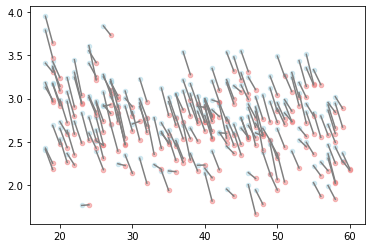

In [10]:
# check whether the generated data make sense
#plot_longitudinal(v1_cont['age'].to_numpy(), v2_cont['age'].to_numpy(), v1_cont[random_idp], v2_cont[random_idp])
plot_longitudinal(v1_pat['age'].to_numpy(), v2_pat['age'].to_numpy(), v1_pat[random_idp], v2_pat[random_idp])

### Run the normative model

In [11]:
# Run the normative model and attach the results to the data
###
# Train_test_split - split across sites, keep 30% as TESTING
###
def run_and_attach(v1_cont, v2_cont, v1_pat, v2_pat, simulations_dir, random_idp):

    from temp_func import pretrained_adapt_controls

    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
    
    for train, test in sss.split(v1_cont.index,  v1_cont['sex']):

        #iter_dir = isim_dir
        #os.makedirs(iter_dir, exist_ok=True)
        site_ids_te =  sorted(set(v1_pat['site'].to_list()))

        for ivisit in range(1,3):
            if ivisit == 1:
                df_te = v1_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            elif ivisit == 2:
                df_te = v2_pat
                df_tec = v2_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            visit_dir = os.path.join(simulations_dir, 'V'+str(ivisit))
            os.makedirs(visit_dir, exist_ok=True)
            

            #custom.pretrained_adapt_small(random_idp, site_ids_tr, site_ids_te, model_path, visit_dir, df_ad, df_te)
            pretrained_adapt_controls([random_idp], site_ids_tr, site_ids_te, models_pretrained_all, visit_dir, df_ad, df_tec, df_te)

            # create textfiles for checking
            df_te.to_csv(os.path.join(visit_dir,random_idp, 'patients.csv'), sep=' ', index=True)
            df_tec.to_csv(os.path.join(visit_dir,random_idp, 'controls_test.csv'), sep=' ', index=True)
            df_ad.to_csv(os.path.join(visit_dir, random_idp, 'controls_adapt.csv'), sep=' ', index=True)

    # Attach
    # Load testing controls and poatients (original dataframes) and attach the z-scores
    v1_cont = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'controls_test.csv'), sep=' ', index_col=0)
    v2_cont = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'controls_test.csv'), sep=' ', index_col=0)

    v1_pat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'patients.csv'), sep=' ', index_col=0)
    v2_pat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'patients.csv'), sep=' ', index_col=0)

    v1_cont_z = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'Z_conttest.txt'), sep=' ', header=None)
    v2_cont_z = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'Z_conttest.txt'), sep=' ', header=None)

    v1_pat_z = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'Z_predict.txt'), sep=' ', header=None)
    v2_pat_z = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'Z_predict.txt'), sep=' ', header=None)

    v1_cont_yhat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'yhat_conttest.txt'), sep=' ', header=None)
    v2_cont_yhat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'yhat_conttest.txt'), sep=' ', header=None)

    v1_pat_yhat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'yhat_predict.txt'), sep=' ', header=None)
    v2_pat_yhat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'yhat_predict.txt'), sep=' ', header=None)

    v1_cont_y = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'y_conttest.txt'), sep=' ', header=None)
    v2_cont_y = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'y_conttest.txt'), sep=' ', header=None)

    v1_pat_y = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'y_predict.txt'), sep=' ', header=None)
    v2_pat_y = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'y_predict.txt'), sep=' ', header=None)

    # Attach the z-scores to the original dataframes
    v1_cont[random_idp+'_z_orig'] = v1_cont_z[0].to_numpy()
    v1_cont[random_idp+'_yhat'] = v1_cont_yhat[0].to_numpy()
    v1_cont[random_idp+'_y'] = v1_cont_y[0].to_numpy()

    v2_cont[random_idp+'_z_orig'] = v2_cont_z[0].to_numpy()
    v2_cont[random_idp+'_yhat'] = v2_cont_yhat[0].to_numpy()
    v2_cont[random_idp+'_y'] = v2_cont_y[0].to_numpy()

    v1_pat[random_idp+'_z_orig'] = v1_pat_z[0].to_numpy()
    v1_pat[random_idp+'_yhat'] = v1_pat_yhat[0].to_numpy()
    v1_pat[random_idp+'_y'] = v1_pat_y[0].to_numpy()

    v2_pat[random_idp+'_z_orig'] = v2_pat_z[0].to_numpy()
    v2_pat[random_idp+'_yhat'] = v2_pat_yhat[0].to_numpy()
    v2_pat[random_idp+'_y'] = v2_pat_y[0].to_numpy()

    return v1_cont, v2_cont, v1_pat, v2_pat

In [37]:
v1_cont, v2_cont, v1_pat, v2_pat = run_and_attach(v1_cont, v2_cont, v1_pat, v2_pat, simulations_dir, random_idp)


Running IDP 0 lh_G_front_sup_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 0 lh_G_front_sup_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 0 lh_G_front_sup_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing out

### Comparison of model performance with the orignal data
- so now the tricky part comes
- first, just compare the z-scores, which, ideally, should reflect the **pop** parameter across visits and subjects

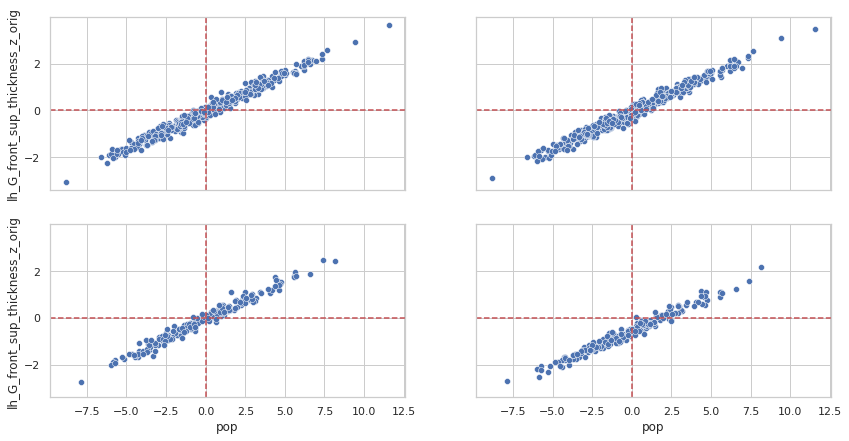

In [15]:
# Plot the z-scores
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(2,2, figsize=(14,7), sharex=True, sharey=True)
sns.scatterplot(data=v1_cont, x='pop', y=random_idp+'_z_orig', ax=ax[0,0])
sns.scatterplot(data=v2_cont, x='pop', y=random_idp+'_z_orig', ax=ax[0,1])
sns.scatterplot(data=v1_pat, x='pop', y=random_idp+'_z_orig', ax=ax[1,0])
sns.scatterplot(data=v2_pat, x='pop', y=random_idp+'_z_orig', ax=ax[1,1])
for i in range(2):
    for j in range(2):
        ax[i,j].axhline(y=0, color='r', linestyle='--')
        ax[i,j].axvline(x=0, color='r', linestyle='--')


### **Compute longitudinal statistics**

In [38]:
nom = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat']))
cont_var = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat'])).var()
cont_z = nom/np.sqrt(cont_var)

nom = ((v2_cont_cont_y - v2_cont_cont_yhat) - (v1_cont_cont_y - v1_cont_cont_yhat))
cont_cont_z = nom/np.sqrt(cont_var)

#nom = ((v2_pat[random_idp+'_y'] - v2_pat[random_idp+'_yhat']) - (v1_pat[random_idp+'_y'] - v1_pat[random_idp+'_yhat']))
#pat_z = nom/np.sqrt(cont_var)


In [41]:
print(cont_cont_z.var())
print(cont_cont_z.mean())

print(cont_z.var())
print(cont_z.mean())

#sns.histplot(cont_z, color='g', kde=True)
#sns.histplot(pat_z, color='r', kde=True)


0    1.096819
dtype: float64
0   -0.126193
dtype: float64
1.0000000000000002
-0.21434852379234481


In [51]:
import xarray as xr
a = np.empty([3,2,2])

pk = xr.DataArray(a, dims=['iters', 'stats', 'idp'], coords={'iters': [1,2,3], 'stats': ['mean','var'], 'idp': ['idp1','idp2']})

In [105]:
#%run simulation_study_cycle.py
!python /home/barbora/Documents/Projects/Normative_Models/ESO/code/simulation_study_cycle.py

Random seed 42 has been set.
lh_G&S_frontomargin_thickness
0.5
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Loading data ...
Prediction by model  1 of 1
Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites miss

In [87]:
import xarray as xr


### Trying to do the same with the **COINS** dataset

In [37]:
# Here load the variances from test-retest data - to compare the variances from our data
v1_y_coins = pd.read_csv(os.path.join(project_dir, 'COINS', 'models', 'threshold_50_y_included','CORR_V1_Y.csv'), sep=' ', index_col=0)
v2_y_coins = pd.read_csv(os.path.join(project_dir, 'COINS', 'models', 'threshold_50_y_included','CORR_V2_Y.csv'), sep=' ', index_col=0)

v1_yhat_coins = pd.read_csv(os.path.join(project_dir, 'COINS', 'models', 'threshold_50_y_included','CORR_V1_Yhat.csv'), sep=' ', index_col=0)
v2_yhat_coins = pd.read_csv(os.path.join(project_dir, 'COINS', 'models', 'threshold_50_y_included','CORR_V2_Yhat.csv'), sep=' ', index_col=0)


In [38]:
# difference in COINS models
coins_diff = (v2_y_coins[idp_ids] - v2_yhat_coins[idp_ids]) - (v1_y_coins[idp_ids] - v1_yhat_coins[idp_ids])
coins_diff['site'] = v1_y_coins['site']

In [39]:
# Load ESO data
from pretrained_long_adapt import analysis_pretrained_adapt_controls
long_patients, long_controls = analysis_pretrained_adapt_controls(only_load=1, preproc='long', test_size=0.7)

ESO_diff = ((long_controls.sel(roi=idp_ids, visit='v2', preproc='y_orig').features - long_controls.sel(roi=idp_ids, visit='v2', preproc='yhat_orig').features
) - (
    long_controls.sel(roi=idp_ids, visit='v1', preproc='y_orig').features - long_controls.sel(roi=idp_ids, visit='v1', preproc='yhat_orig').features)).to_dataframe().unstack()

ESO_diff = ESO_diff['features']
ESO_diff['site'] = 'NUDZ'

Random seed 42 has been set.


In [158]:
# concatenate ESO and coins dataset
diff = pd.concat([coins_diff, ESO_diff], axis=0)
#v1_cont = pd.concat([v1_coins, ESO_diff], axis=0)

In [274]:
import pymc3 as pm
import arviz as az
diff['sitenum'], sites = pd.factorize(diff['site'])

# arviz coordinates preparation
coords = {
    "site": sites,
    "sub_id": diff.index,
}

In [297]:
with pm.Model(coords=coords) as hier_model:
    
    site_idx = pm.Data("site_idx", diff['sitenum'], dims="sub_id")

    # underlying distribution for all sites (only for intercept now)
    mu_mu = pm.Normal("mumu", 0, 1)
    sigma_mu = pm.Exponential("sigmamu", 1/2)

    lamb = pm.Exponential("lamb", 1/2)

    # site specific intercept+
    site_mu = pm.Normal("sitemu", mu_mu, sigma_mu, dims="site")
    site_var = pm.Exponential("sitevar", lamb, dims="site")

    # model
    model_mu = site_mu[site_idx]
    model_sigma = site_var[site_idx]

    y = pm.Normal('y', model_mu, sigma=model_sigma, observed=diff[idp])
    #trace = pm.sample(3000, tune=2000, return_inferencedata=True, nuts_kwargs=dict(target_accept=0.9), random_seed=42)
    
#pm.model_to_graphviz(hier_model)
#plt.savefig(os.path.join(paper_im_dir, 'hierarchical_model.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

In [164]:
# Define Hierarchical Bayesian Regression (using PYMC3)
for iidp, idp in enumerate(idp_ids[0]):
    if iidp != 184:
        with pm.Model() as hier_model:
            
            # underlying distribution for all sites (only for intercept now)
            mu_mu = pm.Normal("mumu", 0, 1)
            sigma_mu = pm.Exponential("sigmamu", 1/2)

            lamb = pm.Exponential("lamb", 1/2)

            # site specific intercept+
            site_mu = pm.Normal("sitemu", mu_mu, sigma_mu, shape=diff['sitenum'].nunique())
            site_var = pm.Exponential("sitevar", lamb, shape=diff['sitenum'].nunique())

            # model
            model_mu = site_mu[diff['sitenum']]
            model_sigma = site_var[diff['sitenum']]

            y = pm.Normal('y', model_mu, sigma=model_sigma, observed=diff[idp])
            trace = pm.sample(3000, tune=3000, target_accept=0.8, return_inferencedata=True)
        
        pk = az.summary(trace)
        temp[iidp,:] = np.array([pk['mean'].loc['alpha[5]'], pk['mean'].loc['sigma_a'], pk['mean'].loc['mu_a']])

        if (np.mod(iidp, 10) == 0) & (iidp!=0) :
            np.savetxt(os.path.join(models_dir, 'BHR_temp.csv'), temp, delimiter=' ')

    pd.DataFrame(temp, index = idp_ids, columns=['mean', 'var', 'alpha_mean']).to_csv(os.path.join(models_dir, 'BHR_y.csv'), sep=' ')

INFO (theano.gof.compilelock): Refreshing lock /home/barbora/.theano/compiledir_Linux-4.19--amd64-x86_64-with-glibc2.28--3.9.7-64/lock_dir/lock


KeyError: 'l'

In [265]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mumu,-0.16,0.11,-0.38,0.04,0.00,0.0,7600.30,5675.52,9575.04,6384.26,1.0
sitemu[0],-0.12,0.12,-0.33,0.12,0.00,0.0,12094.16,7563.19,12196.26,7732.44,1.0
sitemu[1],-0.09,0.15,-0.38,0.20,0.00,0.0,13107.86,6944.33,13054.20,8811.51,1.0
sitemu[2],-0.27,0.05,-0.37,-0.18,0.00,0.0,10091.57,10091.57,10174.54,5660.31,1.0
sitemu[3],-0.11,0.10,-0.29,0.07,0.00,0.0,12518.42,8530.41,12502.66,7467.76,1.0
sitemu[4],-0.40,0.09,-0.57,-0.22,0.00,0.0,5703.51,5703.51,5765.07,1356.46,1.0
sitemu[5],0.00,0.06,-0.11,0.10,0.00,0.0,8612.98,4749.47,8620.29,5956.27,1.0
sigmamu,0.23,0.13,0.06,0.43,0.00,0.0,5197.44,5197.44,2939.87,1386.35,1.0
lamb,1.84,0.71,0.63,3.16,0.01,0.0,12283.91,11058.55,12204.21,7201.68,1.0
sitevar[0],0.47,0.11,0.29,0.68,0.00,0.0,10962.86,9352.03,13355.04,7123.56,1.0


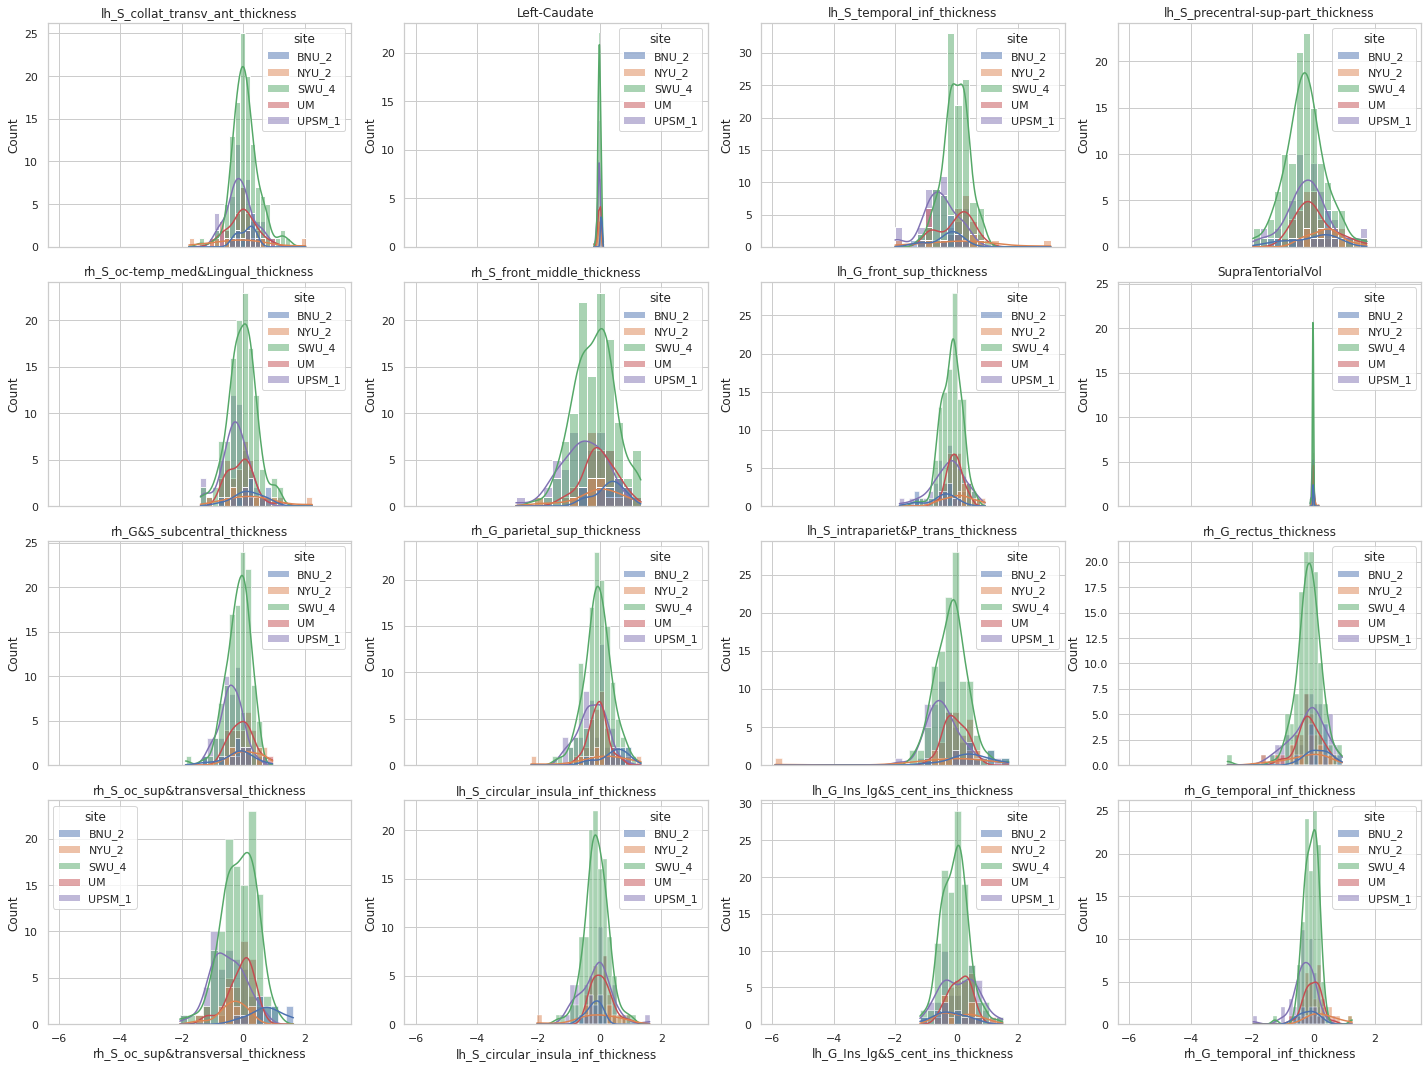

In [78]:
roi = np.random.randint(0, len(idp_ids)+1,16)
var_to_plot = pd.DataFrame(coins_diff[[*[idp_ids[iroi] for iroi in roi], 'site']])

fig, ax = plt.subplots(4,4, figsize=(20,15), sharex=True)
for iplot, iroi in enumerate(roi):
    sns.histplot(data=var_to_plot[[idp_ids[iroi],'site']], x = idp_ids[iroi], hue='site', kde=True, ax=ax.flatten()[iplot])
    ax.flatten()[iplot].set_title(idp_ids[iroi])
    #ax.flatten()[iplot].set_ylabel('Test size (%)')
    #ax.flatten()[iplot].set_xlabel('estimated s2 across 5 CV folds')
    #ax.flatten()[iplot].set_yticklabels(['80', '70', '75', '50', '30', '25', '20'])
    #ax.flatten()[iplot].axvline(s2n, color='r', linestyle='--')
plt.tight_layout()
#plt.savefig(os.path.join(paper_im_dir,'sensitivity_analysis_variance.png'), dpi=100, bbox_inches='tight')

In [79]:
# Functions neede for the simulation study (will be later transfered to custom --- after debugging)
# Function to generate Subjects
def generate_longitudinal_subjects(model_path, simulations_dir, no_females = 1000, var_population = 1, var_noise = 0.5, effect='none', effect_size = 0, effect_var = 0):
    """
    Function will generate brain data based on coeffitiens from chosen model
    generate_longitudinal_subjects(model_path, simulations_dir, no_females = 1000, var_population = 1, var_noise = 0.5):
    
    model_path... path of model with coeffitients
    simulations_dir... where the results are to be stored
    no_females... number of females (dataset is going to be twice the size, default = 1000)
    var_population... variation in population (default = 1)
    var_noise... variation in noise (default = 0.5)
    effect...   - none (use to generate controls)
                - uniform
                - normal
    effect_size... effect size (default = 0)
    effect_var... effect variation (default = 0)
    """
    from pcntoolkit.normative import estimate, predict, evaluate

    # Create template dataset for V1 and V2
    #elems = np.arange(18,60,1)
    #v1_age = np.repeat(elems,no_females/100)
    #v1_age = np.concatenate([v1_age,v1_age])
    v1_age = np.random.randint(18,60,size=no_females*2)
    

    v2_age = v1_age+1

    sex = np.concatenate([np.zeros([no_females]),np.ones([no_females])])
    id = ['c'+str(i) for i in range(1,no_females*2+1)]

    v1_template = pd.DataFrame(np.array([v1_age,sex]).T, columns=['age', 'sex'], index=id)
    v2_template = pd.DataFrame(np.array([v2_age,sex]).T, columns=['age', 'sex'], index=id)

    v1_template['site'] = 'simulation'
    v1_template['sitenum'] = 4223
    v2_template['site'] = 'simulation'
    v2_template['sitenum'] = 4223

    # Deterministic part of the simulation
    # phi(x)*w --> Yhat
    cols_cov = ['age','sex']
    v1_covars = create_design_matrix(v1_template[cols_cov], 
                                site_ids = v1_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)

    v2_covars = create_design_matrix(v2_template[cols_cov], 
                                site_ids = v2_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)


    v1_fsaveto = os.path.join(simulations_dir,'v1_controls.txt')
    np.savetxt(v1_fsaveto, v1_covars)
    v2_fsaveto = os.path.join(simulations_dir,'v2_controls.txt')
    np.savetxt(v2_fsaveto, v2_covars)

    from temp_func_pcn import predict
    v1_template['Yhat'], v1_s2_orig = predict(v1_fsaveto, respfile = None, alg='blr', model_path=model_path)
    v2_template['Yhat'], v2_s2_orig = predict(v2_fsaveto, respfile = None, alg='blr', model_path=model_path)

    # Adding the position within the population to every individual
    np.random.seed(42)

    if var_population == 'model':
        with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, v1_covars)        
        v1_template['pop'] = np.random.normal(0, 1/beta, size=v1_template.shape[0])
        beta = 1/beta
    else:
        v1_template['pop'] = np.random.normal(0,var_population,size=v1_template.shape[0])
        beta = var_population + var_noise

    # Adding the effect if there is any (controls vs patients)
    if effect == 'none':
        effect_size = 0
    elif effect == 'normal':
        effect_size = np.random.normal(effect_size, effect_var, size=no_patients)
    elif effect == 'uniform':
        effect_size = effect_size

    v1_template['effect_size'] = effect_size
    v1_template['Yhat_pop'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['effect_size']
    v1_template['noise'] = np.random.normal(0,var_noise,size=v1_template.shape[0])
    v1_template['warped'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['effect_size'] + v1_template['noise']

    v2_template['pop'] = v1_template['pop']
    v2_template['effect_size'] = effect_size
    v2_template['Yhat_pop'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['effect_size']
    v2_template['noise'] = np.random.normal(0,var_noise,size=v2_template.shape[0])
    v2_template['warped'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['effect_size'] + v2_template['noise']


    # Now warping into the original space
    # load the normative model
    with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    v1_template[random_idp] = W.warp_predictions(np.squeeze(v1_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]
    v2_template[random_idp] = W.warp_predictions(np.squeeze(v2_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]

    return(v1_template, v2_template, beta)


###
# Train_test_split - split across sites, keep 30% as TESTING
###
def run_and_attach(v1_cont, v2_cont, v1_pat, v2_pat, simulations_dir, random_idp):

    from temp_func import pretrained_adapt_controls

    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
    
    for train, test in sss.split(v1_cont.index,  v1_cont['sex']):

        #iter_dir = isim_dir
        #os.makedirs(iter_dir, exist_ok=True)
        site_ids_te =  sorted(set(v1_pat['site'].to_list()))

        for ivisit in range(1,3):
            if ivisit == 1:
                df_te = v1_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            elif ivisit == 2:
                df_te = v2_pat
                df_tec = v2_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            visit_dir = os.path.join(simulations_dir, 'V'+str(ivisit))
            os.makedirs(visit_dir, exist_ok=True)
            

            #custom.pretrained_adapt_small(random_idp, site_ids_tr, site_ids_te, model_path, visit_dir, df_ad, df_te)
            pretrained_adapt_controls([random_idp], site_ids_tr, site_ids_te, models_pretrained_all, visit_dir, df_ad, df_tec, df_te)

            # create textfiles for checking
            df_te.to_csv(os.path.join(visit_dir,random_idp, 'patients.csv'), sep=' ', index=True)
            df_tec.to_csv(os.path.join(visit_dir,random_idp, 'controls_test.csv'), sep=' ', index=True)
            df_ad.to_csv(os.path.join(visit_dir, random_idp, 'controls_adapt.csv'), sep=' ', index=True)

    # Attach
    # Load testing controls and poatients (original dataframes) and attach the z-scores
    v1_cont = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'controls_test.csv'), sep=' ', index_col=0)
    v2_cont = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'controls_test.csv'), sep=' ', index_col=0)

    v1_pat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'patients.csv'), sep=' ', index_col=0)
    v2_pat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'patients.csv'), sep=' ', index_col=0)

    v1_cont_z = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'Z_conttest.txt'), sep=' ', header=None)
    v2_cont_z = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'Z_conttest.txt'), sep=' ', header=None)

    v1_pat_z = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'Z_predict.txt'), sep=' ', header=None)
    v2_pat_z = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'Z_predict.txt'), sep=' ', header=None)

    v1_cont_yhat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'yhat_conttest.txt'), sep=' ', header=None)
    v2_cont_yhat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'yhat_conttest.txt'), sep=' ', header=None)

    v1_pat_yhat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'yhat_predict.txt'), sep=' ', header=None)
    v2_pat_yhat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'yhat_predict.txt'), sep=' ', header=None)

    v1_cont_y = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'y_conttest.txt'), sep=' ', header=None)
    v2_cont_y = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'y_conttest.txt'), sep=' ', header=None)

    v1_pat_y = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'y_predict.txt'), sep=' ', header=None)
    v2_pat_y = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'y_predict.txt'), sep=' ', header=None)

    # Attach the z-scores to the original dataframes
    v1_cont[random_idp+'_z_orig'] = v1_cont_z[0].to_numpy()
    v1_cont[random_idp+'_yhat'] = v1_cont_yhat[0].to_numpy()
    v1_cont[random_idp+'_y'] = v1_cont_y[0].to_numpy()

    v2_cont[random_idp+'_z_orig'] = v2_cont_z[0].to_numpy()
    v2_cont[random_idp+'_yhat'] = v2_cont_yhat[0].to_numpy()
    v2_cont[random_idp+'_y'] = v2_cont_y[0].to_numpy()

    v1_pat[random_idp+'_z_orig'] = v1_pat_z[0].to_numpy()
    v1_pat[random_idp+'_yhat'] = v1_pat_yhat[0].to_numpy()
    v1_pat[random_idp+'_y'] = v1_pat_y[0].to_numpy()

    v2_pat[random_idp+'_z_orig'] = v2_pat_z[0].to_numpy()
    v2_pat[random_idp+'_yhat'] = v2_pat_yhat[0].to_numpy()
    v2_pat[random_idp+'_y'] = v2_pat_y[0].to_numpy()

    return v1_cont, v2_cont, v1_pat, v2_pat

# LONGITUDINAL PLOTTING FUNCTION
# check the controls are not dramatically different between the two visits
# x coordinates - age - two rows of data
def plot_longitudinal(v1_age, v2_age,  v1_Yhat, v2_Yhat, to_plot = True, v1_col='lightblue', v2_col='lightcoral', tick_col = 'gray', title = '', xlabel = 'Age', ylabel = 'Yhat'):
    """
    The function will plot the longitudinal data as connected dots
    plot_longitudinal(v1_age, v2_age,  v1_Yhat, v2_Yhat, to_plot = True, v1_col='lightblue', v2_col='lightcoral', tick_col = 'gray', title = '', xlabel = 'Age', ylabel = 'Yhat')
    
    v1_age, v2_age... what will be plotted on x axis, ideally 1xn 2D array
    v1_Yhat, v2_Yhat... what will be plotted on y axis, ideally 1xn 2D array
    to_plot... if True, the plot will be shown, if False, the plot will be returned
    v1_col, v2_col, tick_col... color of the dots for the first and second visit
    title, xlabel, ylabel... title and labels of the plot
    """
    def check_dimensions(vector):
        """
        check_dimensions(vector)
        reshapes array into 2D 1xn array
        """
        if len(vector.shape) == 1:
            return vector[np.newaxis,:]
        elif len(vector.shape) == 2:
            if vector.shape[0] > vector.shape[1]:
                return vector.T
            else:
                return vector
        else:
            return False

    v1_age = check_dimensions(v1_age)
    v2_age = check_dimensions(v2_age)
    v1_Yhat = check_dimensions(v1_Yhat)
    v2_Yhat = check_dimensions(v2_Yhat)
    
    x_coords = np.concatenate([v1_age, v2_age],axis=0)
    y_coords = np.concatenate([v1_Yhat, v2_Yhat],axis=0)

    if to_plot:
        fig, ax = plt.subplots()
        plt.plot(x_coords, y_coords, color=tick_col)
        plt.scatter(v1_age, v1_Yhat, color=v1_col, s=20, alpha = 0.5)
        plt.scatter(v2_age, v2_Yhat, color=v2_col, s=20, alpha = 0.5)

    return ax




# Loading packages
import os, glob, pickle, time, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pcntoolkit.util.utils import create_design_matrix

# custom functions
code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)
import clinics_desc_functions as custom

custom.set_seed(seed=42)

# Paths to directoris
project_dir = ('/home/barbora/Documents/Projects/Normative_Models')
simulations_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/simulations'
models_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/models/lifespan_57K_82sites/'
models_pretrained_all = '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/'
paper_im_dir = os.path.join(project_dir,'ESO', 'draft', 'img')

# pretrained model
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()
thick_idp = [i for i in idp_ids if 'thick' in i]

# create empty data array (3D) to store the results in
#data = np.empty(len(np.arange(0.5, 5.5, 0.5)) * len(np.arange(0.25, 2.25, 0.25)), 6, len(thick_idp))
data = np.empty([len(np.arange(0.5, 5.5, 0.5)) * len(np.arange(0.25, 2.25, 0.25)), 6, 2])
random_idp = idp_ids[15]

###
# This is going to be the first cycle acroos idps
###
for i, idp in enumerate(idp_ids[15]):#np.random.randint(len(idp_ids), size=1)
    print(idp)

    # one random model - just trying to get some reasonable coeffitients
    model_path = os.path.join(models_dir,random_idp,'Models')

    # to define row in the data
    irow = 0
    for ivar_population in np.arange(0.5, 5.5, 0.5):
        for ivar_noise in np.arange(0.25, 2, 0.25):
            ###
            # Generate controls and patients
            ###
            v1_cont, v2_cont, s2_model = generate_longitudinal_subjects(model_path, simulations_dir, no_females = 1000, var_population = ivar_population, var_noise = ivar_noise, effect='none')
            v1_pat, v2_pat, s2_model = generate_longitudinal_subjects(model_path, simulations_dir, no_females = 100, var_population = ivar_population, var_noise = ivar_noise, effect='none')
            
            ###
            # potential effect - not now, only checking controls
            #v2_pat[random_idp] = v2_pat[random_idp] - 0.2

            ###
            # Run and attach the results of normative model
            v1_cont, v2_cont, v1_pat, v2_pat = run_and_attach(v1_cont, v2_cont, v1_pat, v2_pat, simulations_dir, random_idp)

            ###
            # Statistics
            nom = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat']))
            cont_var = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat'])).var()
            cont_z = nom/np.sqrt(cont_var)

            nom = ((v2_pat[random_idp+'_y'] - v2_pat[random_idp+'_yhat']) - (v1_pat[random_idp+'_y'] - v1_pat[random_idp+'_yhat']))
            pat_z = nom/np.sqrt(cont_var)

            data[irow, 0, i] = ivar_population
            data[irow, 1, i] = ivar_noise
            data[irow, 2, i] = cont_z.mean()
            data[irow, 3, i] = cont_z.var()
            data[irow, 4, i] = pat_z.mean()
            data[irow, 5, i] = pat_z.var()

            irow += 1


Random seed 42 has been set.


TypeError: list indices must be integers or slices, not list

In [ ]:


df_data = xr.DataArray(data, dims=['iters', 'stats', 'idp'], coords={'stats': ['pop_var', 'noise_var', 'cont_mean', 'cont_var', 'pat_mean', 'pat)var'], 'idp': thick_idp[15]})
#df_data = xr.DataArray(data, dims=['iters', 'stats', 'idp'], coords={'iters': [1,2,3], 'stats': ['mean','var'], 'idp': thick_idp})
df_data.to_netcdf(os.path.join(simulations_dir, "sim_trial.nc"))
